## How can we assign atom type and other info to wildcard atoms after BRICS decompose?

In [9]:
from rdkit.Chem.Lipinski import RotatableBondSmarts
from rdkit.Chem import BRICS
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem.FeatMaps import FeatMaps
from rdkit.Chem import AllChem, rdShapeHelpers
from rdkit import RDConfig
from rdkit.Chem import rdFMCS

import os
import numpy as np
import pandas as pd
from datetime import datetime

date = datetime.today().strftime('%Y-%m-%d')

def getBits(mol):
    '''

    Parameters
    ----------
    mol : rdkit mol object to be broken up into fragments by breaking 
    rotable bonds

    Returns
    -------
    mols : A list of rdkit mol objects

    '''
    # Try break everything up - aromatics and aliphatics into single bits!
    smart_breaks = Chem.MolFromSmarts('[!R][R]')
    
    # find the rotatable bonds
    bonds = mol.GetSubstructMatches(smart_breaks)
    
    bonds = [((x,y),(0,0)) for x,y in bonds]
    p = BRICS.BreakBRICSBonds(mol,bonds=bonds)
 
    mols = [mol for mol in Chem.GetMolFrags(p,asMols=True)]
    
    return mols

# Function to build feature maps and score two mol objects
fdef = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef'))

fmParams = {}
for k in fdef.GetFeatureFamilies():
    fparams = FeatMaps.FeatMapParams()
    fmParams[k] = fparams

keep = ('Donor', 'Acceptor', 'NegIonizable', 'PosIonizable', 'ZnBinder',
        'Aromatic', 'Hydrophobe', 'LumpedHydrophobe')

def getFeatureMapScore(small_m, large_m, score_mode=FeatMaps.FeatMapScoreMode.All):
    try: 
        featLists = []
        for m in [small_m, large_m]:
            rawFeats = fdef.GetFeaturesForMol(m)
            # filter that list down to only include the ones we're interested in
            featLists.append([f for f in rawFeats if f.GetFamily() in keep])
        fms = [FeatMaps.FeatMap(feats=x, weights=[1] * len(x), params=fmParams) for x in featLists]
        fms[0].scoreMode = score_mode
        fm_score = fms[0].ScoreFeats(featLists[1]) / min(fms[0].GetNumFeatures(), len(featLists[1]))
        return fm_score
    except ZeroDivisionError:
        return 0


In [14]:
# Use if we want to load docking sdf file
compound_mols = Chem.SDMolSupplier('/home/warren/XChem_projects/xchem-XCOS/in_data/Fragmenstein_permissive_rescored_20200609.sdf')

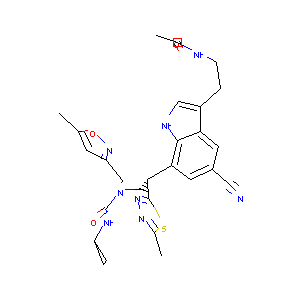

In [21]:
test_mol = compound_mols[2]
Draw.MolToImage(test_mol)

In [22]:
## How does BRICS assign atom ids?
compound_bits = getBits(test_mol)

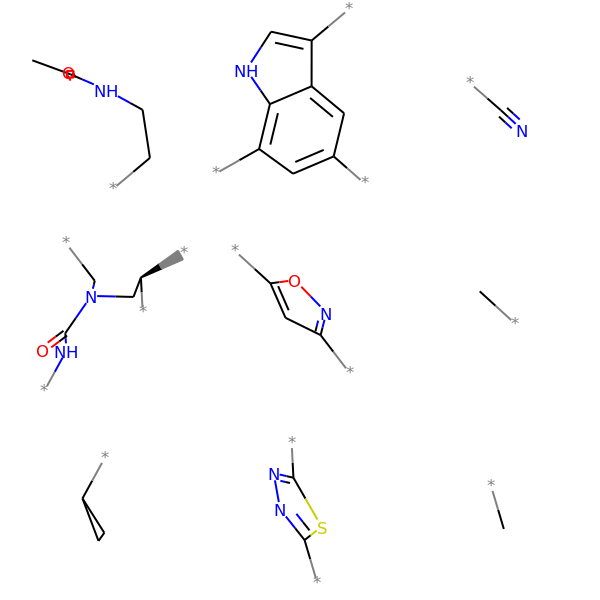

In [23]:
Draw.MolsToGridImage(compound_bits)

In [37]:
for atom in compound_bits[3].GetAtoms():
    print(atom.GetSymbol(), atom.GetIdx())

C 0
C 1
N 2
C 3
C 4
O 5
N 6
* 7
* 8
* 9
* 10


In [43]:
# Let's remove wildcard atoms
bit_1_no_wildcard = Chem.DeleteSubstructs(compound_bits[2], Chem.MolFromSmarts('[#0]'))

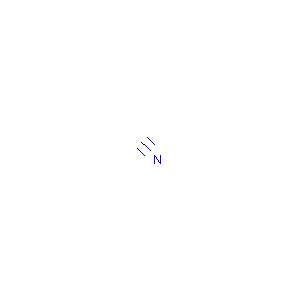

In [44]:
Draw.MolToImage(bit_1_no_wildcard)